<a href="https://colab.research.google.com/github/tsakailab/DeepLS/blob/main/demo/demo_cell_segmentation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Deep learning for Foreground Segmentation Exploiting Low-rank and Sparse Priors

In [1]:
#@title import pytorch and fix seed
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_reserved())
    torch.cuda.empty_cache()
import random
import numpy as np
def torch_fix_seed(seed=0):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed(seed=0)

Tesla T4
0
0


In [2]:
#@title some functions for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from torchvision.utils import make_grid

def anim_make(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[1]):
        V = []
        for l in range(len(MM)):
            V.append(MM[l][:,i].reshape(hw))
        #ims.append( [plt.imshow(np.abs(M[:,i]).reshape(hw), cmap='gray', vmin=vmin, vmax=vmax)] )
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

def anim_make_for_UNet(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[0]):
        V = []
        for l in range(len(MM)):
            # print(MM[l][i].shape, MM[l].shape)
            V.append(MM[l][i])
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

def make_and_plot_grid(data, nrows=8):
    fig = plt.figure(figsize=(nrows*4,8))
    data = torch.tensor(data).unsqueeze(1)
    grid = make_grid(data, nrow=nrows).permute(1,2,0)
    plt.imshow(grid)


def plot_loss(historyr):
    plt.rcParams["font.size"] = 16
    fig = plt.figure()
    plt.plot(list(loss_hist['total'].values()), label='Total loss')
    plt.plot(list(loss_hist['nuclear'].values()), label='Nuclear norm')
    plt.plot(list(loss_hist['l1'].values()), label='L1 norm')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [3]:
#@title Download and extract data zipfile
import urllib.error
import urllib.request
import os
import ssl

file_url = "https://cs.adelaide.edu.au/~carneiro/isbi14_challenge/Train45Test90.zip"
os.makedirs("./tmp/", exist_ok=True)
save_path = "./tmp/isbi"

if not os.path.exists("./tmp/isbi/isbi_train.mat"):
    ctx = ssl.create_default_context()
    ctx.options |= 0x4  # ssl.OP_LEGACY_SERVER_CONNECT
    resposne = urllib.request.urlopen(file_url, context=ctx)
    data = resposne.read()
    with open("./tmp/isbi.zip", mode='wb') as save_file:
        save_file.write(data)

    import zipfile
    zip_filename = "./tmp/isbi.zip"
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(save_path)
    zip_ref.close()

imageseq_files = sorted(os.listdir(save_path))

import scipy.io
data = scipy.io.loadmat("./tmp/isbi/isbi_train.mat")
data_array = np.array(data["ISBI_Train"])
ret_array = lambda x: data_array[x][0]
data_array = np.array(list(map(ret_array, np.arange(len(data_array)))))
data_array = data_array / 255.

label = scipy.io.loadmat("./tmp/isbi/isbi_train_GT.mat")
label_array = np.array(label["train_Cytoplasm"])
ret_array = lambda x: label_array[x][0]
label_array = np.array(list(map(ret_array, np.arange(len(label_array)))))

test = scipy.io.loadmat("./tmp/isbi/isbi_test90.mat")
test_array = np.array(test["ISBI_Test90"])
ret_array = lambda x: test_array[x][0]
test_array = np.array(list(map(ret_array, np.arange(len(test_array)))))
test_array = test_array / 255.

test_label = scipy.io.loadmat("./tmp/isbi/isbi_test90_GT.mat")
test_label_array = np.array(test_label["test_Cytoplasm"])
ret_array = lambda x: test_label_array[x][0]
test_label_array = np.array(list(map(ret_array, np.arange(len(test_label_array)))))

label_train = []
for i in range(label_array.shape[0]):
    tmp = np.zeros((512,512))
    for j in range(label_array[i].shape[0]):
        # print(label_array[i][j][0].shape)
        tmp += label_array[i][j][0]
    tmp[tmp!= 0] = 1
    label_train.append(tmp)
label_train = np.array(label_train)

label_test = []
for i in range(test_label_array.shape[0]):
    tmp = np.zeros((512,512))
    for j in range(test_label_array[i].shape[0]):
        tmp += test_label_array[i][j][0]
    tmp[tmp!= 0] = 1
    label_test.append(tmp)
label_test = np.array(label_test)

print("The loading of data set \"Training Phase\" from ISBI 2014 dataset is completed.")
print("Training images:", data_array.shape)
print("Test images:", test_array.shape)

<ipython-input-3-8e3bb1f9d2e3>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_array = np.array(list(map(ret_array, np.arange(len(label_array)))))
<ipython-input-3-8e3bb1f9d2e3>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_label_array = np.array(list(map(ret_array, np.arange(len(test_label_array)))))


The loading of data set "Training Phase" from ISBI 2014 dataset is completed.
Training images: (45, 512, 512)
Test images: (90, 512, 512)


# Randomly select validation data from Training images and prepare test data.
- n_images(int): Number of validation images

In [4]:
n_images = 13

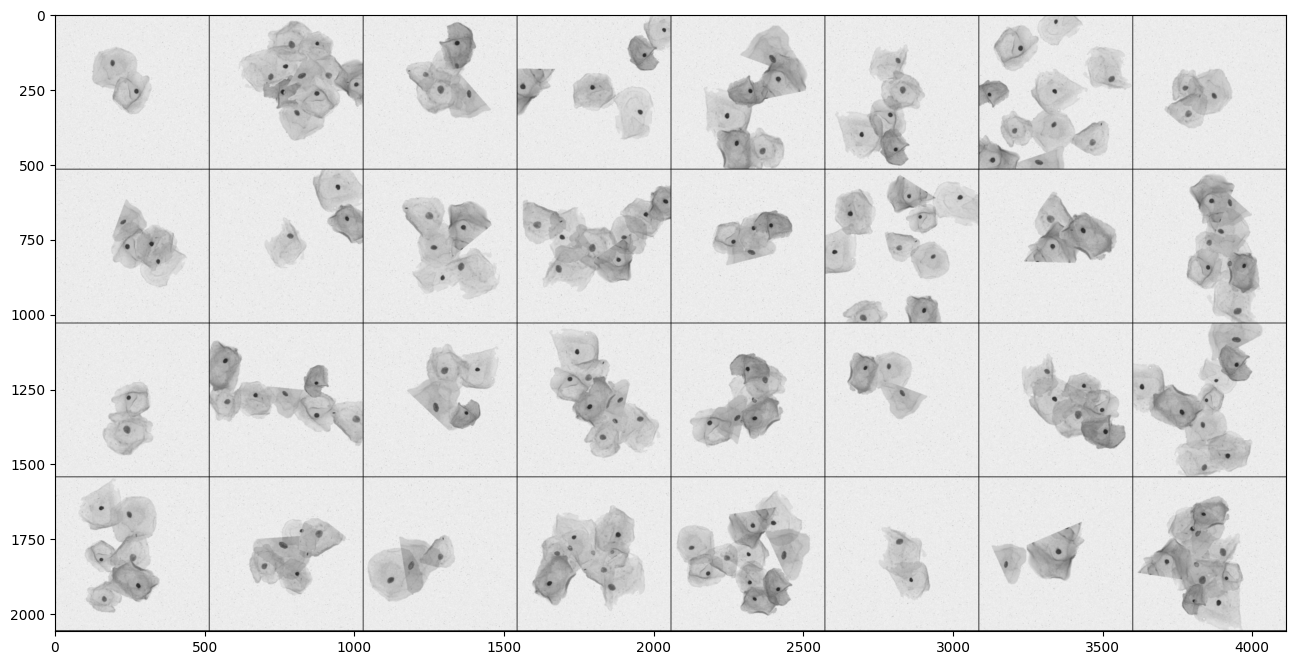

In [5]:
#@title plot training set
from sklearn.model_selection import train_test_split
D_train, D_val, l_train, l_val = train_test_split(data_array, label_train, test_size=n_images, random_state=0)
n, m = D_train.shape[0], D_train.shape[-2]*D_train.shape[-1]
make_and_plot_grid(D_train)

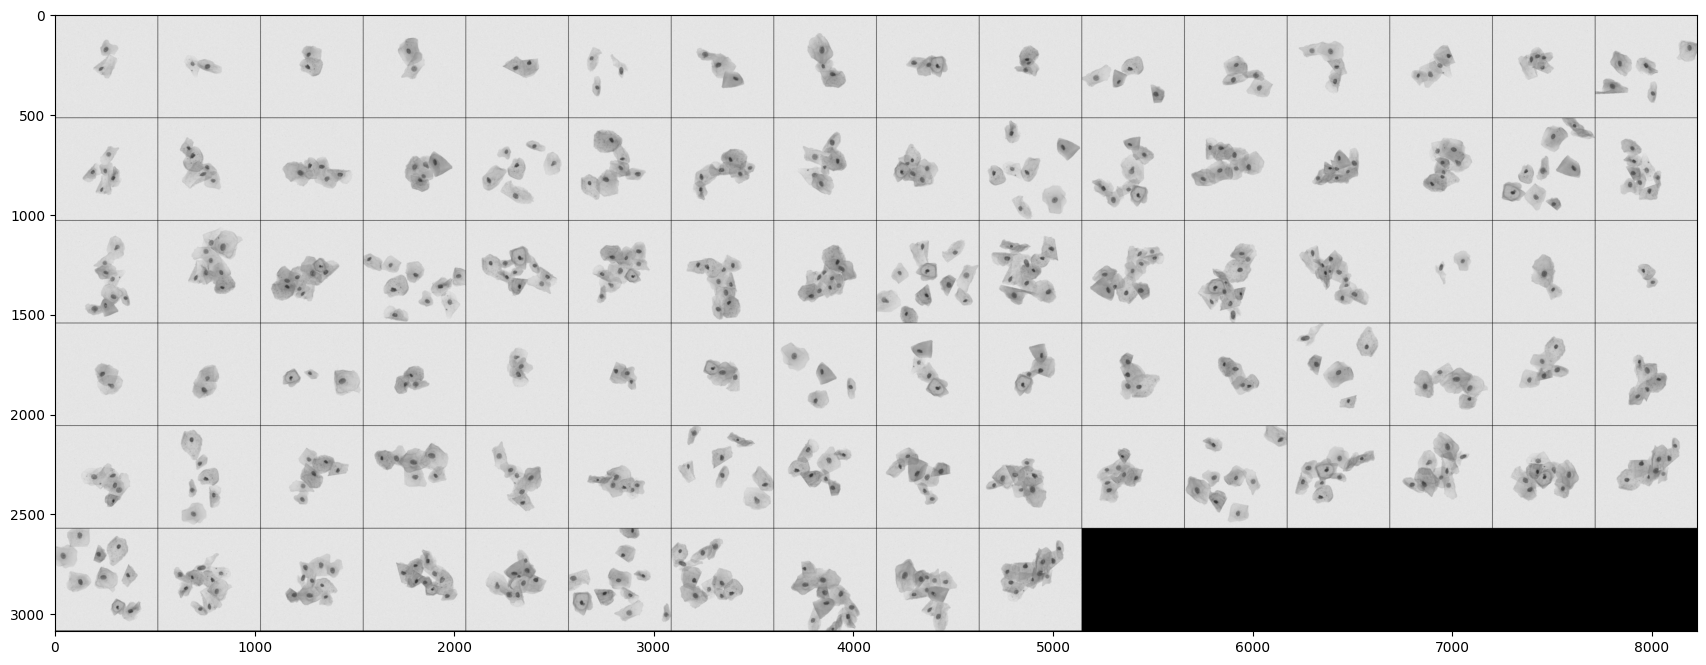

In [6]:
#@title plot test set
D_test = test_array
make_and_plot_grid(D_test, nrows=16)

# Try our unsupervised deep learning approach!
![](https://github.com/tsakailab/DeepLS/blob/main/model_architecture.png?raw=1)

In [7]:
#@title initialize our model
class dualframeUNet(torch.nn.Module):
    def __init__(self, in_channels, middle_channels_c, output_channels):
        super().__init__()
        def double_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(out_channels, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True)
            )
        def middle_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(out_channels, in_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(in_channels),
                torch.nn.ReLU(inplace=True)
            )
        def out_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, in_channels//2, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(in_channels//2),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels//2, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True)
            )
        def last_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 1, padding=0, bias=False)
            )
        def upsample(in_channels, out_channels, scale_factor, mode):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=scale_factor, mode=mode),
            )

        self.convs1 = double_conv(in_channels,middle_channels_c)
        self.downsample1 = torch.nn.MaxPool2d(2)
        self.convs2 = double_conv(middle_channels_c,middle_channels_c*2)
        self.downsample2 = torch.nn.MaxPool2d(2)
        self.convs3 = middle_conv(middle_channels_c*2,middle_channels_c*4)

        self.upsample2_S = upsample(middle_channels_c*2, middle_channels_c*2, 2, 'bilinear')
        self.dconvs2_S = out_conv(middle_channels_c*4,middle_channels_c*1)
        self.upsample1_S = upsample(middle_channels_c*1, middle_channels_c*1, 2, 'bilinear')

        self.dconvs1_S = double_conv(middle_channels_c*2,middle_channels_c)
        self.last_S = last_conv(middle_channels_c,output_channels)

    def forward(self, x):
        #encoding                           #x:(B,input_channels,H,W)
        convs1 = self.convs1(x)             #x:(B,c,H,W)
        x_down1 = self.downsample1(convs1)  #x:(B,c,H/2,W/2)
        convs2 = self.convs2(x_down1)       #x:(B,c*2,H/2,W/2)
        x_down2 = self.downsample1(convs2)  #x:(B,c*2,H/4,W/4)
        x = self.convs3(x_down2)            #x:(B,c*2,H/4,W/4)

        #decoding
        x = self.upsample2_S(x - x_down2)   #x:(B,c*2,H/2,W/2)
        x = torch.cat([x, convs2], dim=1)   #x:(B,c*4,H/2,W/2)
        x = self.dconvs2_S(x)               #x:(B,c,H/2,W/2)

        x = self.upsample1_S(x - x_down1)   #x:(B,c,H,W)
        x = torch.cat([x, convs1], dim=1)   #x:(B,c*2,H,W)
        x = self.dconvs1_S(x)               #x:(B,c,H,W)

        out_S = self.last_S(x)              #x:(B,c,H,W) out_S:(B,1,H,W)

        return out_S
from torchsummary import summary
model = dualframeUNet(in_channels=1, middle_channels_c=16, output_channels=1).cuda()
summary(model, (1, 512, 512), batch_size=45-n_images)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 512, 512]             160
       BatchNorm2d-2         [32, 16, 512, 512]              32
              ReLU-3         [32, 16, 512, 512]               0
            Conv2d-4         [32, 16, 512, 512]           2,320
       BatchNorm2d-5         [32, 16, 512, 512]              32
              ReLU-6         [32, 16, 512, 512]               0
         MaxPool2d-7         [32, 16, 256, 256]               0
            Conv2d-8         [32, 32, 256, 256]           4,640
       BatchNorm2d-9         [32, 32, 256, 256]              64
             ReLU-10         [32, 32, 256, 256]               0
           Conv2d-11         [32, 32, 256, 256]           9,248
      BatchNorm2d-12         [32, 32, 256, 256]              64
             ReLU-13         [32, 32, 256, 256]               0
        MaxPool2d-14         [32, 32, 1

In [8]:
#@title implemention of the computation of two norms $\|L\|_*,\|S\|_1$ used for loss function
# pytorch implementation
Nuclear_loss = lambda x: torch.svd(x.view(x.shape[0], -1))[1].sum()
Group_L1_loss = lambda x, eps: (x.pow(2).sum(1)+eps).sqrt().sum() #eps=1e-5 # for color output
L1_loss = lambda x: x.abs().sum()
TV_loss = lambda x: (x[:, :, 1:, :]-x[:, :, :-1, :]).abs().sum()+(x[:, :, :, 1:]-x[:, :, :, :-1]).abs().sum()

In [16]:
#@title hyperparameter setting
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
lambda_sparse = 1/np.sqrt(max(m, n))
lambda_TV = 5e-3

100%|██████████| 100/100 [01:44<00:00,  1.04s/it, loss=3.64e+3, nuclear_norm=3.37e+3, L1_norm=205, TV_loss=67.8]


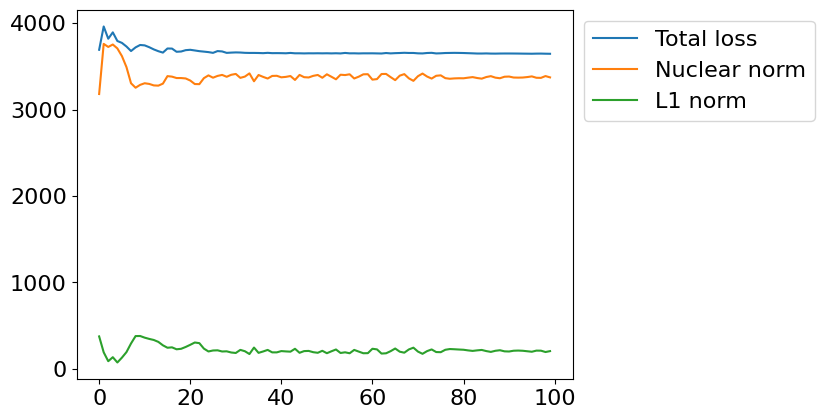

In [17]:
#@title run training (about 6 min for 32 training images with 500 epochs)
from tqdm import tqdm
from collections import OrderedDict

# prepare training data
DD_UNet = torch.tensor(D_train).unsqueeze(1).float().cuda()
DD_UNet_test = torch.tensor(D_test).unsqueeze(1).float().cuda()
LL_UNet = torch.tensor(l_train).unsqueeze(1).float().cuda().cpu().squeeze(1)
LL_UNet_test = torch.tensor(label_test).unsqueeze(1).float().cuda().cpu().squeeze(1)

history_loss_Unet = []
loss_hist = {}
loss_hist['total'] = {}
loss_hist['l1'] = {}
loss_hist['nuclear'] = {}
loss_hist['TV'] = {}

bar = tqdm(total = num_epochs, position=0, leave=True)
for iter in range(num_epochs):
    total_loss = 0.

    # predict foreground
    S = model(DD_UNet)
    L = DD_UNet-S

    # compute loss
    nloss = Nuclear_loss(L)
    lloss = L1_loss(S)*lambda_sparse
    TVloss = TV_loss(S)*lambda_TV
    loss = nloss + lloss + TVloss

    # optimize model parameter
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    history_loss_Unet.append(total_loss)
    bar.set_postfix(OrderedDict(loss=total_loss, nuclear_norm=nloss.item(), L1_norm=lloss.item(), TV_loss=TVloss.item()))
    loss_hist['total'][iter] = loss.item()
    loss_hist['l1'][iter] = lloss.item()
    loss_hist['nuclear'][iter] = nloss.item()
    loss_hist['TV'][iter] = TVloss.item()
    bar.update(1)
bar.close()
### Results
plot_loss(loss_hist)
model = model.eval()

<ipython-input-2-1514fd45ed67>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).unsqueeze(1)


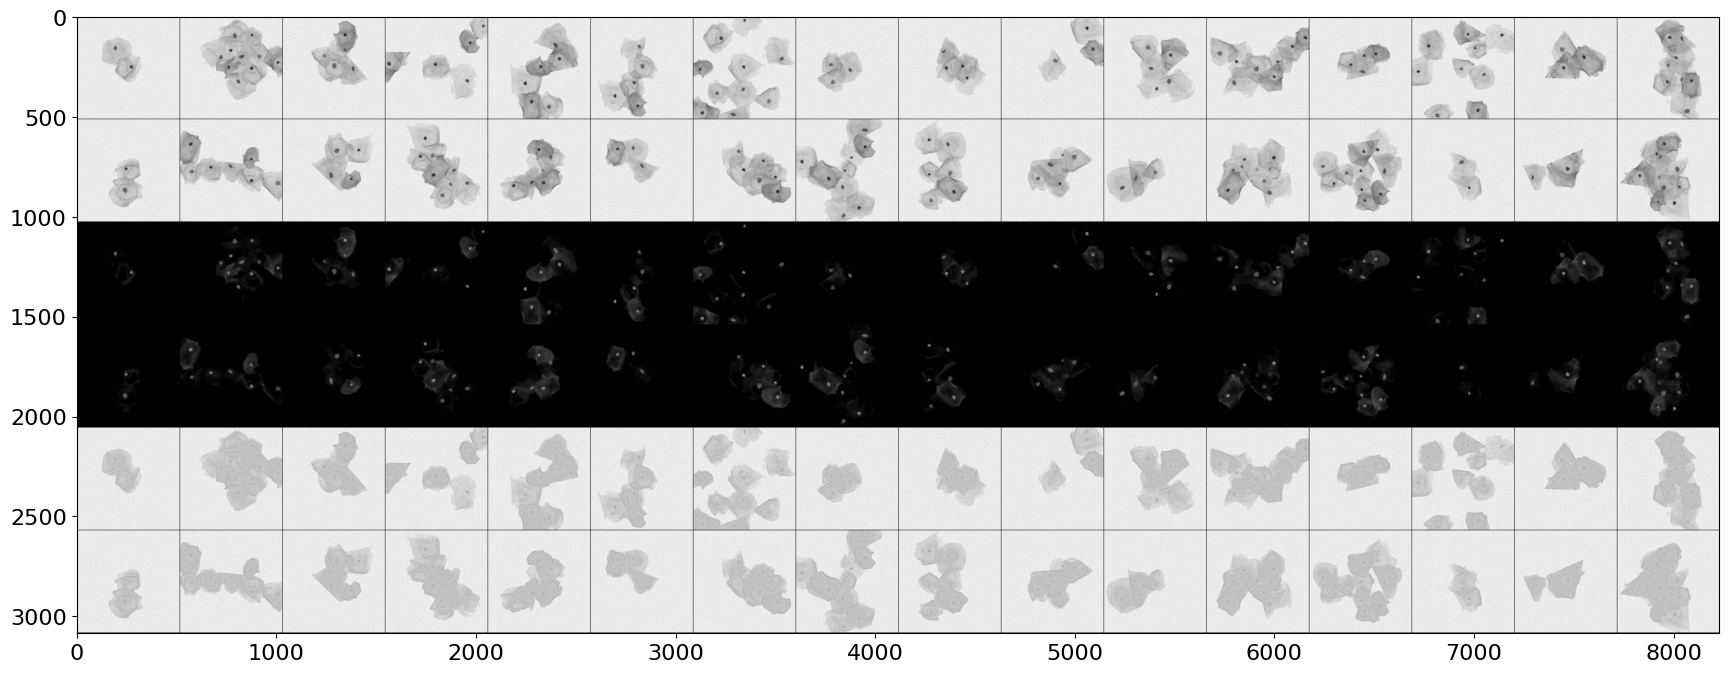

In [18]:
#@title output of our model (for train set)
D_UNet = DD_UNet.cpu().squeeze(1)                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet).detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)      # L=D-S     :(batch size, image height, image width)

make_and_plot_grid(torch.cat((D_UNet, S_UNet.abs(), L_UNet),0), nrows=16)

<ipython-input-22-9aa76ad0eba2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D_UNet = torch.tensor(DD_UNet_test).cpu().squeeze(1)[:10]                   # D         :(batch size, image height, image width)
<ipython-input-2-1514fd45ed67>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).unsqueeze(1)


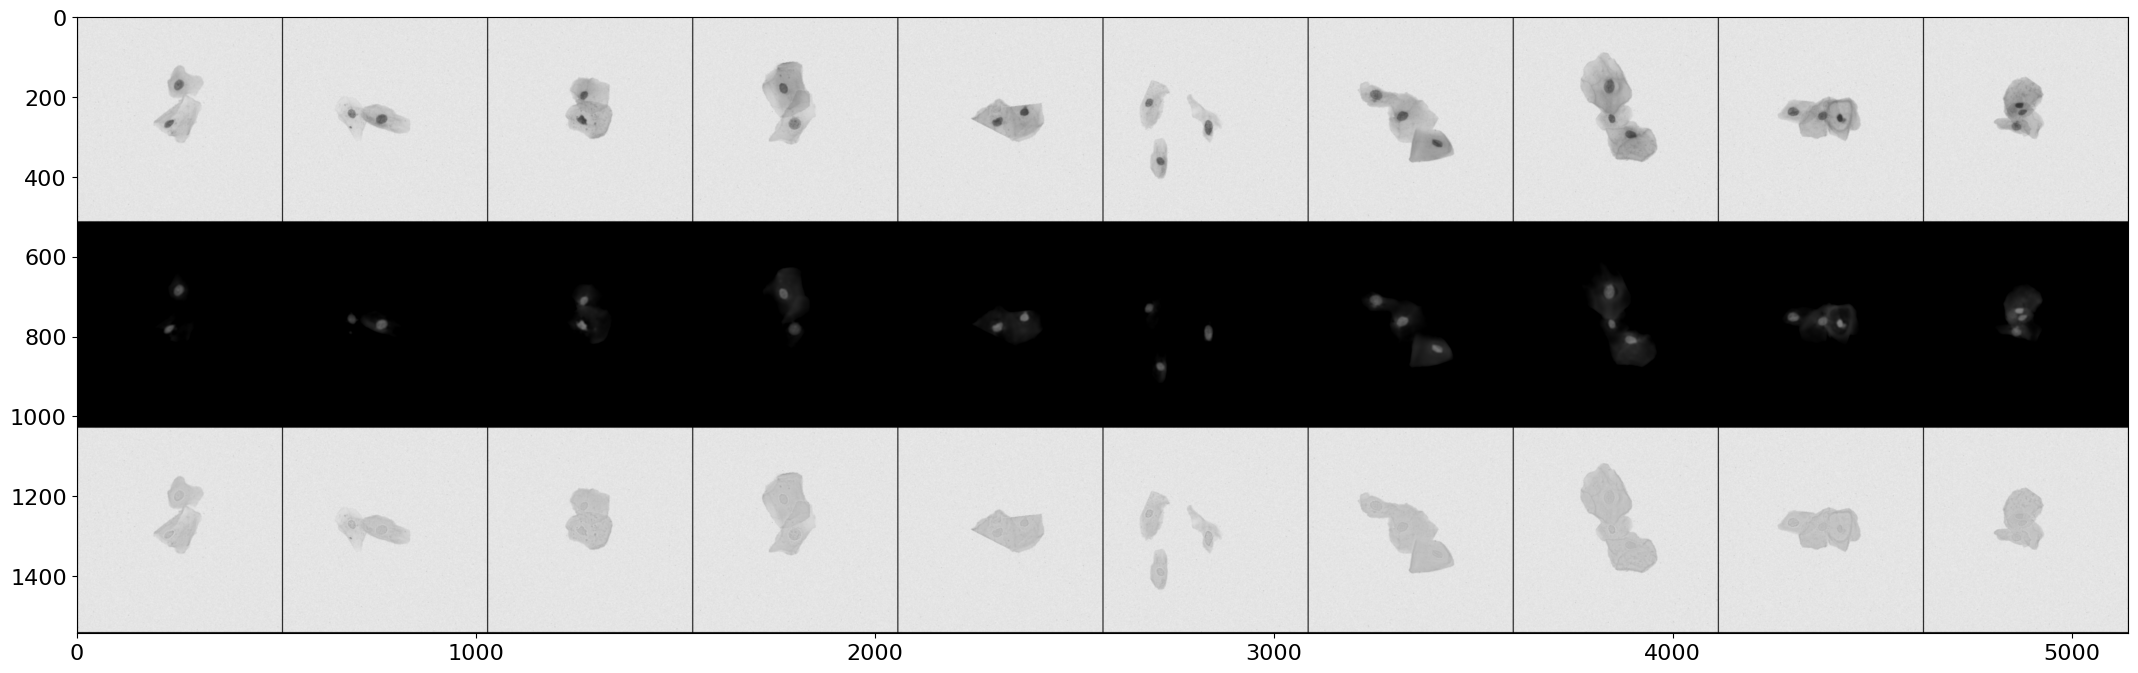

In [22]:
#@title output of our model (for test set)
D_UNet = torch.tensor(DD_UNet_test).cpu().squeeze(1)[:10]                   # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet_test[:10].float().cuda()).detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)                  # L=D-S     :(batch size, image height, image width)

# DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet, LL_UNet_test  ], (D_UNet.shape[-2], D_UNet.shape[-1]), interval=300)
# HTML(DLDiffanim.to_html5_video())

make_and_plot_grid(torch.cat((D_UNet, S_UNet.abs(), L_UNet),0), nrows=10)